In [56]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import os, json

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
!pwd

/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE


In [13]:
elections = os.path.join("~","BAYESIAN-REPOS","MY-RAOS-LECTURE", "DATA", 
                    "ElectionsEconomy")
hibbs = os.path.join("data","hibbs.dat")

In [14]:
filepath = os.path.join(elections, hibbs)
df = pd.read_csv(filepath, sep="\s+")
df.rename(columns={'vote':'inc_party_vote'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 16 non-null     int64  
 1   growth               16 non-null     float64
 2   inc_party_vote       16 non-null     float64
 3   inc_party_candidate  16 non-null     object 
 4   other_candidate      16 non-null     object 
dtypes: float64(2), int64(1), object(2)
memory usage: 768.0+ bytes


In [15]:
df.head()

,year,growth,inc_party_vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon


In [17]:
formula = 'inc_party_vote ~ growth'
linear_model = smf.ols(formula=formula, data=df).fit()
linear_model.summary()

/Users/seanreed1/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         inc_party_vote   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     19.32
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           0.000610
Time:                        10:32:40   Log-Likelihood:                -42.839
No. Observations:                  16   AIC:                             89.68
Df Residuals:                      14   BIC:                             91.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.2476      1.622     28.514      0.000      42.769      49.726
growth         3.0605      0.696      4.396      0.001       1.567       4.554
==============================================================================
Omnibus:                        5.392   Durbin-Watson:                   2.379
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                2.828
Skew:                          -0.961   Prob(JB):                        0.243
Kurtosis:                       3.738   Cond. No.                         4.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[go here for the original graph from RAOS --> ElectionsEconomy.html](https://avehtari.github.io/ROS-Examples/ElectionsEconomy/hibbs.html)

### Plot of the linear regression model

### inc_party_vote = 46.25 + 3.06 * growth

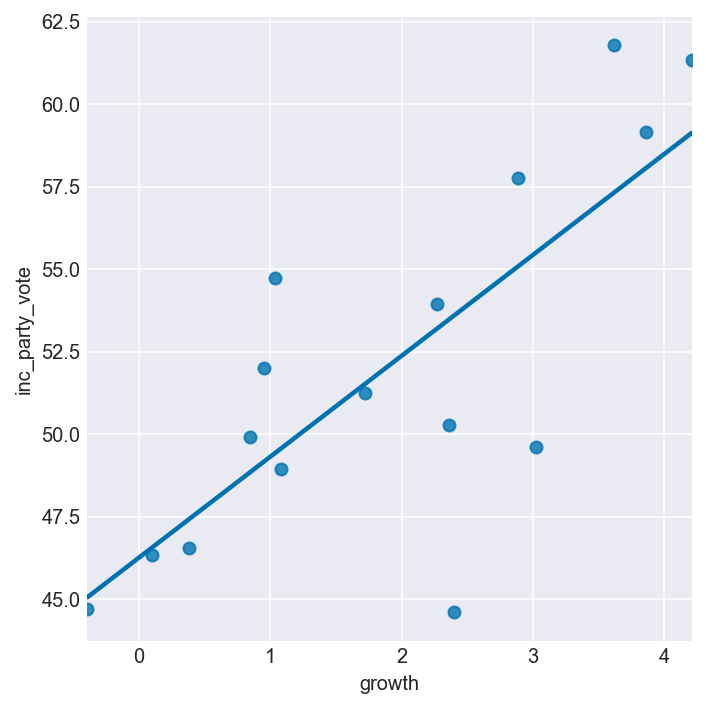

In [31]:
sns.lmplot(x='growth', y='inc_party_vote', data=df, ci=False)

Now let's make our first model with CmdStanPy

In [50]:
from cmdstanpy import CmdStanModel
import json

In [ ]:
we need to make a stan file, and then compile into a CmdStanModel

We need three sections, one for the input data, one for the model parameters (and priors), and one for the stan model itself 

In [80]:
election = '''
data {
  int<lower=0> N;
  vector[N] growth;
  vector[N] inc_party_vote;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  inc_party_vote ~ normal(alpha + beta * growth, sigma);
}

'''

In [81]:
with open('election.stan', 'wt') as f:
    f.write(election)

Now we need to write the election data as json

In [55]:
election = df[['growth', 'inc_party_vote']]

election.head()

,growth,inc_party_vote
0,2.40,44.60
1,2.89,57.76
2,0.85,49.91
3,4.21,61.34
4,3.02,49.60


In [ ]:
# #bernoulli_data.json

# {
#     "N" : 10,
#     "y" : [0,1,0,0,0,0,0,0,0,1]
# }

In [74]:
election_data = {"N":len(election), "growth":list(election.growth),'inc_party_vote':list(election.inc_party_vote) }
election_data

{'N': 16,
 'growth': [2.4,
  2.89,
  0.85,
  4.21,
  3.02,
  3.62,
  1.08,
  -0.39,
  3.86,
  2.27,
  0.38,
  1.04,
  2.36,
  1.72,
  0.1,
  0.95],
 'inc_party_vote': [44.6,
  57.76,
  49.91,
  61.34,
  49.6,
  61.79,
  48.95,
  44.7,
  59.17,
  53.94,
  46.55,
  54.74,
  50.27,
  51.24,
  46.32,
  52.0]}

In [76]:
with open('election_data.json', 'wt') as f:
    f.write(json.dumps(election_data))

In [88]:
from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path

In [87]:
cmdstan_path()

'/Users/seanreed1/.cmdstanpy/cmdstan-2.22.1'

In [82]:
election_model = CmdStanModel(stan_file='election.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/election
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
ERROR:cmdstanpy:file /Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/election.stan, exception ERROR
 error: PCH file uses an older PCH format that is no longer supported
1 error generated.
make: *** [make/program:44: /Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/election] Error 1 
ERROR:cmdstanpy:model compilation failed


ValueError: Unable to compile Stan model file: /Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/election.stan.

In [85]:
m = CmdStanModel(str(model_path))
m

NameError: name 'model_path' is not defined

In [83]:
!cat election.stan


data {
  int<lower=0> N;
  vector[N] growth;
  vector[N] inc_party_vote;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  inc_party_vote ~ normal(alpha + beta * growth, sigma);
}



In [47]:
# import os
from cmdstanpy import cmdstan_path, CmdStanModel


election_model = CmdStanModel(stan_file='election.stan')
election_model.name
bernoulli_model.stan_file
bernoulli_model.exe_file
bernoulli_data = os.path.join(cmdstan_path(), 'examples', 'bernoulli', 'bernoulli.data.json')
bern_fit = bernoulli_model.sample(data=bernoulli_data, output_dir='.')

print(bern_fit)
bern_fit.summary()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/seanreed1/.cmdstanpy/cmdstan-2.22.1/examples/bernoulli/bernoulli
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


CmdStanMCMC: model=bernoulli chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-1.csv
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-2.csv
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-3.csv
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-4.csv
 output_files:
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-1-stdout.txt
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-2-stdout.txt
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-3-stdout.txt
	/Users/seanreed1/BAYESIAN-REPOS/MY-RAOS-LECTURE/bernoulli-202010021115-4-stdout.txt


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.283240,0.017581,0.726826,-8.783130,-7.005600,-6.750150,1709.05,12629.8,1.00145
theta,0.245886,0.003179,0.119473,0.076325,0.231183,0.466909,1412.77,10440.3,1.00117


In [45]:
print(bernoulli_model.code())

data { 
  int<lower=0> N; 
  int<lower=0,upper=1> y[N];
} 
parameters {
  real<lower=0,upper=1> theta;
} 
model {
  theta ~ beta(1,1);  // uniform prior on interval 0,1
  y ~ bernoulli(theta);
}



In [ ]:
# # bernoulli.stan

# data { 
#   int<lower=0> N; 
#   int<lower=0,upper=1> y[N];
# } 
# parameters {
#   real<lower=0,upper=1> theta;
# } 
# model {
#   theta ~ beta(1,1);  // uniform prior on interval 0,1
#   y ~ bernoulli(theta);
# }

In [34]:
# #bernoulli_data.json

# {
#     "N" : 10,
#     "y" : [0,1,0,0,0,0,0,0,0,1]
# }

show using standard linear regression model with flat priors

show using standard linear regression model with weakly informative priors